# Influence of Non-Behavioral Features on Fatal Car Accidents Due to Cell Phone Usage #
## Python Code ##
**Madeline M. Warndorf**
Graduate Student, EMSE Dept.
George Washington University
Washington, D.C.
mwarndorf65@gwu.edu

## I. General Analysis of Dataset and Preprocessing
### A. Importing Cleaned Final Dataset

In [186]:
import pandas as pd
from sklearn.utils import shuffle

#Importing Data as Pandas Dataframe
fars_file = "MLEMSE6992/fulldataset1516.csv"
fars_df = pd.read_csv(fars_file)

#print(fars_df.head())
fars_df = shuffle(fars_df)


#Casenum and vehnum were dropped because those were assigned by the police after the accident.
d_col = ['statenum','day','month','year','landuse','age','bodytype','vfatcount','numoccs','modelyr']
t_col = ['cellphone_use']

### B.Determining if Dataset Needs to Be Undersampled

In [187]:
#Determine if there is a need to undersample
celluse = fars_df[fars_df["cellphone_use"] == 1]
no_celluse = fars_df[fars_df["cellphone_use"] == 0]
print("The number of accidents involving cellphones: {}".format(len(celluse)))
print("The number of accidents that did not involve cellphones: {}".format(len(no_celluse)))

total_accidents = len(celluse) + len(no_celluse)
print("The total number of accidents: %d" % total_accidents)
#Percentage of accidents involving cellphones
percentage = (len(celluse)/ total_accidents) * 100
print("The percentage of accidents that involved cellphones: {:.4}%".format(percentage))


The number of accidents involving cellphones: 830
The number of accidents that did not involve cellphones: 77587
The total number of accidents: 78417
The percentage of accidents that involved cellphones: 1.058%


### C. Creating New Dataframe with Undersampled Data
Storing new dataframe as a CSV to allow for this section of code not to be re-run and so the data isn't resampled to produce different answers down the line.

In [188]:
#Need to undersample
m = len(celluse)
selected_no_celluse = no_celluse.sample(m)


#Storing and Shuffling new dataset
undersampled_df = pd.concat([selected_no_celluse, celluse], ignore_index=True)
undersampled_df = shuffle(undersampled_df)

undersampled_df.to_csv("FARS_undersampled_df.csv", sep=",",index=False)


### D. Exploring the Independent Variables
mean of each continuous variable and the mode of each categorical variable

In [342]:

df_all = pd.read_csv("FARS_undersampled_df.csv")

# Categorical categories
categorical_variables = ['statenum','day','month','year','landuse','age','bodytype','modelyr']

print ("__Categorical_Variables__")
for variable in categorical_variables:
    print("%s mode = %s" % (variable, df_all[variable].mode().iloc[0]))
    print("%s number of levels = %s" % (variable, len(np.unique(df_all[variable]))))

# Continuous categories
continuous_variables = ["vfatcount", "numoccs"]
print ("__Continuous_Variables__")

# Print out means for survivors
for variable in continuous_variables:
    print("%s mean = %.2f" % (variable, df_all[variable].mean()))





__Categorical_Variables__
statenum mode = 48
statenum number of levels = 49
day mode = 5
day number of levels = 31
month mode = 12
month number of levels = 12
year mode = 2016
year number of levels = 2
landuse mode = 1
landuse number of levels = 2
age mode = 19
age number of levels = 78
bodytype mode = 4
bodytype number of levels = 18
modelyr mode = 2004
modelyr number of levels = 39
__Continuous_Variables__
vfatcount mean = 0.61
numoccs mean = 1.51


### E. Visualization of Relationships between Cellphone Usage and Each Feature

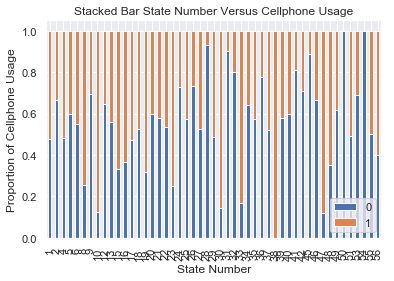

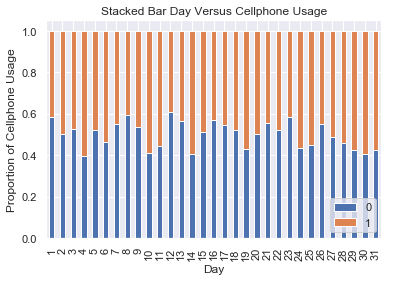

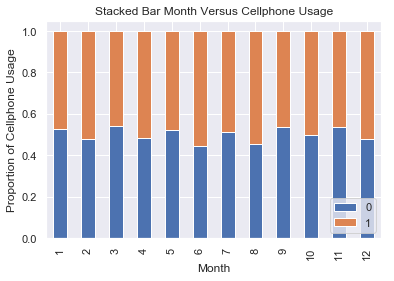

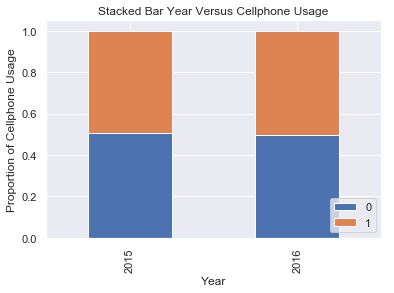

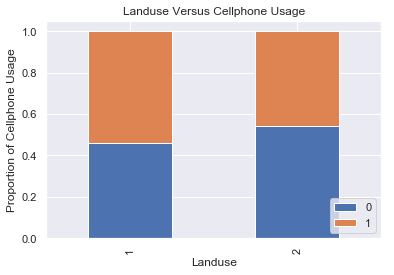

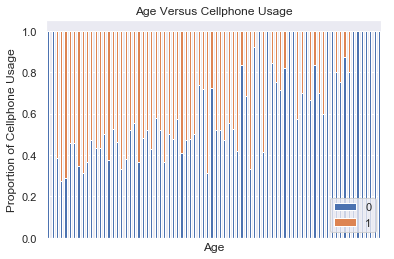

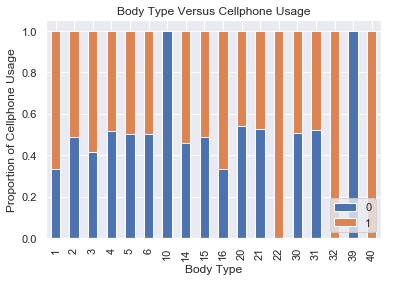

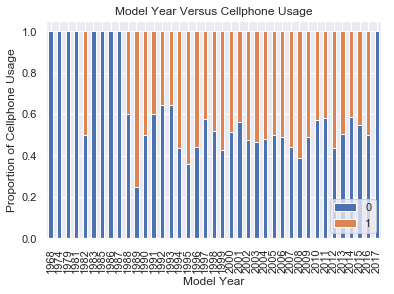

In [395]:
from math import e
import scipy
from scipy import stats
from matplotlib import pyplot as plt

plt.rc("font", size=14)
import seaborn as sns
sns.set(style="dark")
sns.set(style="darkgrid", color_codes=True)

dataframe_all = pd.read_csv("FARS_undersampled_df.csv")

y = dataframe_all["cellphone_use"]


table=pd.crosstab(dataframe_all["statenum"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Stacked Bar State Number Versus Cellphone Usage')
plt.xlabel('State Number')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('State_Versus_Cellphone')

table=pd.crosstab(dataframe_all["day"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Stacked Bar Day Versus Cellphone Usage')
plt.xlabel('Day')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Day_Versus_Cellphone')

table=pd.crosstab(dataframe_all["month"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Stacked Bar Month Versus Cellphone Usage')
plt.xlabel('Month')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Month_Versus_Cellphone')

table=pd.crosstab(dataframe_all["year"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Stacked Bar Year Versus Cellphone Usage')
plt.xlabel('Year')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Year_Versus_Cellphone')

table=pd.crosstab(dataframe_all["landuse"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Landuse Versus Cellphone Usage')
plt.xlabel('Landuse')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Landuse Versus Cellphone Usage')

table=pd.crosstab(dataframe_all["age"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Age Versus Cellphone Usage')
plt.xticks([])
plt.xlabel('Age')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Age Versus Cellphone Usage')

table=pd.crosstab(dataframe_all["bodytype"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Body Type Versus Cellphone Usage')
plt.xlabel('Body Type')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Body Type Versus Cellphone Usage')

table=pd.crosstab(dataframe_all["modelyr"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Model Year Versus Cellphone Usage')
plt.xlabel('Model Year')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Model Year Versus Cellphone Usage')

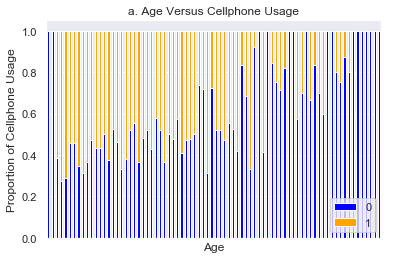

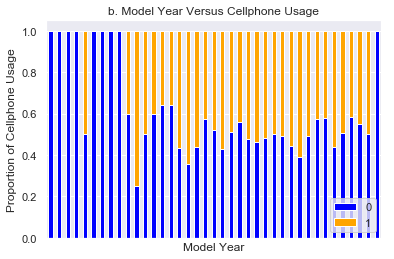

In [231]:

table=pd.crosstab(dataframe_all["age"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['blue','orange'])
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('a. Age Versus Cellphone Usage')
plt.xticks([])
plt.xlabel('Age')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Age Versus Cellphone Usage')


table=pd.crosstab(dataframe_all["modelyr"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['blue','orange'])
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('b. Model Year Versus Cellphone Usage')
plt.xticks([])
plt.xlabel('Model Year')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Model Year Versus Cellphone Usage')

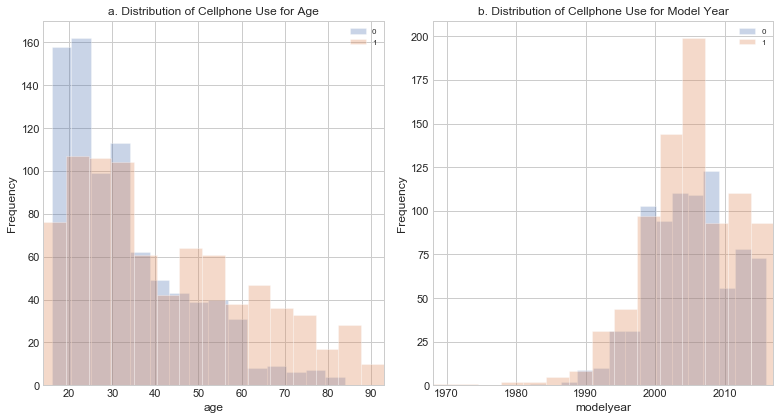

In [328]:
cols = ['age','modelyr']
X = far_data[cols].values
y = far_target.values


from matplotlib import pyplot as plt
import numpy as np
import math

label_dict = {0: 'No-Cellphone',
              1: 'Cellphone'}

feature_dict = {0: 'age',  
                1: 'modelyear'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(11, 6))
    for cnt in range(2):
        plt.subplot(1, 2, cnt+1)
        for lab in (0, 1):
            plt.hist(X[y==lab, cnt],
                     label=lab,
                     bins=15,
                     alpha=0.3,)
            plt.xlim(X[y==lab, cnt].min(), X[y==lab, cnt].max())
        plt.xlabel(feature_dict[cnt])
        plt.ylabel("Frequency")
        if cnt == 0:
            plt.title("a. Distribution of Cellphone Use for Age")
        else:
            plt.title("b. Distribution of Cellphone Use for Model Year")
        plt.legend(loc='upper right', fancybox=True, fontsize=8)

    plt.tight_layout()
    plt.show()

In [235]:
print("Age ranged from: %d to %d." % (dataframe_all["age"].min(),dataframe_all["age"].max()))
print("Model ranged from: %d to %d." % (dataframe_all["modelyr"].min(),dataframe_all["modelyr"].max()))

Age ranged from: 14 to 93.
Model ranged from: 1968 to 2017.


### E. Preprocessing the Data

In [308]:
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
d_col = ['statenum','day','month','year','landuse','age','bodytype','vfatcount','numoccs','modelyr']
#Create data and target
undersampled_df = pd.read_csv("FARS_undersampled_df.csv", sep = ",")
undersampled_df = shuffle(undersampled_df)

far_data = undersampled_df[d_col]

far_dict_data = far_data.T.to_dict('dict').values()
vectorizer = DictVectorizer(sparse=False)
fardata = vectorizer.fit_transform(far_dict_data)


fars_target_raw = undersampled_df['cellphone_use']
df_t = pd.get_dummies(fars_target_raw)
far_target = df_t[0]

fartarget = far_target.values

print(fardata)
print(fartarget)

[[3.300e+01 4.000e+00 1.200e+01 ... 5.300e+01 0.000e+00 2.016e+03]
 [4.500e+01 4.000e+00 2.400e+01 ... 2.100e+01 1.000e+00 2.016e+03]
 [1.800e+01 4.000e+00 1.700e+01 ... 4.200e+01 1.000e+00 2.015e+03]
 ...
 [2.700e+01 3.100e+01 8.000e+00 ... 1.700e+01 0.000e+00 2.015e+03]
 [2.200e+01 6.000e+00 2.500e+01 ... 4.800e+01 1.000e+00 2.015e+03]
 [2.100e+01 2.000e+00 2.500e+01 ... 4.800e+01 1.000e+00 2.016e+03]]
[1 0 1 ... 1 0 0]


## PCA

In [361]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(fardata)


import numpy as np
cov_mat = np.cov(X_std.T)
print('Covariance matrix: \n%s' %np.cov(X_std.T))

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

u,s,v = np.linalg.svd(X_std.T)
u


Covariance matrix: 
[[ 1.00060277e+00  7.18010576e-02  9.53470303e-03  2.99838475e-02
   4.74351041e-02 -1.82939114e-02 -9.23635055e-02 -4.46345774e-02
  -1.23361196e-02  2.28363391e-02]
 [ 7.18010576e-02  1.00060277e+00 -7.86774646e-03 -1.53187872e-01
  -8.19242671e-02  1.30470628e-02  2.32127333e-03  2.81267702e-02
  -1.10501600e-01 -2.15739818e-02]
 [ 9.53470303e-03 -7.86774646e-03  1.00060277e+00  6.66776319e-03
   1.46349764e-03 -4.83584297e-02 -2.51137528e-02 -2.14524019e-02
  -5.80917468e-02  5.43956296e-02]
 [ 2.99838475e-02 -1.53187872e-01  6.66776319e-03  1.00060277e+00
   1.16582034e-01  2.01890389e-02 -2.80910532e-02 -6.46124381e-02
  -2.13024085e-01  3.75912026e-02]
 [ 4.74351041e-02 -8.19242671e-02  1.46349764e-03  1.16582034e-01
   1.00060277e+00  4.16592738e-02  1.72169868e-03 -2.39463695e-02
  -1.96314854e-01  4.60916770e-02]
 [-1.82939114e-02  1.30470628e-02 -4.83584297e-02  2.01890389e-02
   4.16592738e-02  1.00060277e+00  1.28966994e-02 -1.72212595e-02
  -3.88340019

array([[-0.17344699,  0.38531641,  0.11334113, -0.27063052,  0.61993037,
         0.17713862,  0.38678003, -0.34068772,  0.13179695,  0.19139282],
       [ 0.09189816,  0.66974382, -0.29093063,  0.2927923 , -0.02888695,
        -0.01888608,  0.13575982,  0.33467459,  0.25311315, -0.42063614],
       [-0.12224104,  0.12092452,  0.49446706,  0.2702341 , -0.46820885,
        -0.26285148,  0.47857155, -0.35639032, -0.0259024 , -0.08879243],
       [-0.48004616, -0.35673564,  0.00279181, -0.06269013, -0.03122581,
         0.17752202, -0.03336863, -0.08219073,  0.65971037, -0.40346233],
       [-0.4267538 , -0.23991697, -0.14483058,  0.28135198,  0.26433862,
         0.12909358,  0.31652632,  0.18002943, -0.58684451, -0.31090218],
       [-0.07737812, -0.09604472, -0.57014301,  0.01772551,  0.11724055,
        -0.70734587,  0.03054791, -0.37738369,  0.04433495, -0.00317099],
       [ 0.3508597 , -0.38848119, -0.14449835,  0.22631141,  0.07192426,
         0.03926929,  0.59376265,  0.28812944

Everything ok!
Eigenvalues in descending order:
1.4674340603466285
1.179879442220498
1.0993748822490093
1.0235223152564725
0.9919627959811381
0.960640251724395
0.9433876254659359
0.887481823250533
0.8572884320623632
0.5950560989897614
Matrix W:
 [[ 0.17344699 -0.38531641]
 [-0.09189816 -0.66974382]
 [ 0.12224104 -0.12092452]
 [ 0.48004616  0.35673564]
 [ 0.4267538   0.23991697]
 [ 0.07737812  0.09604472]
 [-0.3508597   0.38848119]
 [-0.23789747  0.05118809]
 [-0.57465671  0.2007861 ]
 [ 0.13434818  0.02130183]]


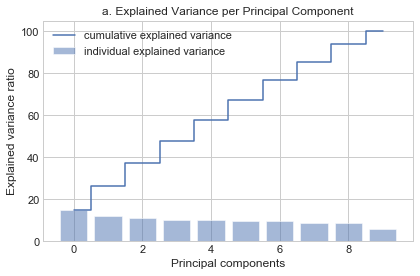

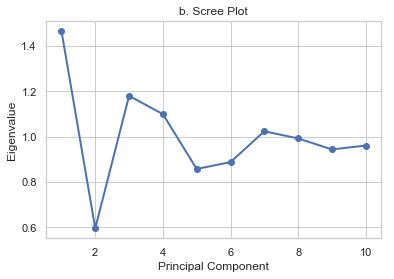

In [362]:
for ev in eig_vecs.T:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])
    
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.title("a. Explained Variance per Principal Component")
    plt.bar(range(10), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(10), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

matrix_w = np.hstack((eig_pairs[0][1].reshape(10,1),
                      eig_pairs[1][1].reshape(10,1)))

print('Matrix W:\n', matrix_w)

plt.figure()
n = len(eig_vals)
x = [i for i in range(1,n+1)]

plt.plot(x, eig_vals,'o-', linewidth=2)
plt.title('b. Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

plt.show()


In [379]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Eigenvalues in descending order:')
for i in eig_pairs:
    if i[0] > 1.0:
        print(i[0])
    
eig_pairs_chosen = eig_pairs[:4]
eig_vals[::-1].sort()
chosen_eig_vals = eig_vals[:4]
#print(eig_vals[:3])

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
n_component_index = len(chosen_eig_vals) - 1

print("The cumulative variance that is explained in this approach is : %.3f" % cum_var_exp[n_component_index])


eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs_chosen = eig_pairs[:5]
chosen_eig_vals = eig_vals[:5]
#print(eig_vals[:3])

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
n_component_index = len(chosen_eig_vals) - 1

print("The cumulative variance that is explained in this approach is : %.3f" % cum_var_exp[n_component_index])

Eigenvalues in descending order:
1.4674340603466285
1.179879442220498
1.0993748822490093
1.0235223152564725
The cumulative variance that is explained in this approach is : 47.673
The cumulative variance that is explained in this approach is : 57.587


## II. Deciding on Model
### A. Finding Best Parameters Using GridSearchCV and the Metric Accuracy
Finding best parameters for each type of model based on accuracy. 

In [330]:
#Using GridSearch to determine the best Logistic Regression Model
#Setting parameters
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
np.random.seed(300)
from warnings import filterwarnings
filterwarnings('ignore')

#Logistic Regression
param_grid = [{'C': [1e-1, 1e0, 1e2], 'solver': ['lbfgs'],'max_iter': [100,1000,5000,10000]},
              {'C': [1e-1, 1e0, 1e2], 'solver': ['liblinear'],'max_iter': [100,1000,5000]}]
lr = LogisticRegression()

me_grid = GridSearchCV(lr, param_grid, cv=10, scoring = 'f1')
me_grid.fit(fardata, fartarget)

print("__MaxEnt (Logistic Regression)__")
print("Best F1 Score: %0.3f" % me_grid.best_score_)
print("Best Parameters set:")
print(me_grid.best_estimator_.get_params())

#Naive Bayes: MultinominalNB
param_gridNB = [{'alpha': [0.01, 0.1, 1.0]}]
mnb = MultinomialNB()

mnb_grid = GridSearchCV(mnb, param_gridNB, cv=10, scoring = 'f1')
mnb_grid.fit(fardata, fartarget)

print("\n")
print("__Naive Bayes (Multinomial)__")
print("Best Score: %0.3f" % mnb_grid.best_score_)
print("Best Parameters set:")
print(mnb_grid.best_estimator_.get_params())

#SVC RBF
svc = svm.SVC()

param_gridSVC = [{'C': [1e0, 1e2, 1e5], 'kernel': ['rbf'], 'gamma': [0.1, 10]}]

svc_grid = GridSearchCV(svc, param_gridSVC, cv=10, scoring = 'f1')

svc_grid.fit(fardata, fartarget)

print("\n")
print("__Support Vector RBF Classifier__")
print("Best F1 Score: %0.3f" % svc_grid.best_score_)
print("Best Parameters set:")
print(svc_grid.best_estimator_.get_params())

#LinearSVC
svcL = svm.LinearSVC()

param_gridSVCL = [{'C': [1e0, 1e2, 1e3], 'loss':['hinge','squared_hinge'], 'max_iter': [1000, 5000, 10000]}]

svc_gridL = GridSearchCV(svcL, param_gridSVCL, cv=10, scoring = 'f1')

svc_gridL.fit(fardata, fartarget)

print("\n")
print("__Support Vector Linear Classifier__")
print("Best F1 Score: %0.3f" % svc_gridL.best_score_)
print("Best Parameters set:")
print(svc_gridL.best_estimator_.get_params())

__MaxEnt (Logistic Regression)__
Best F1 Score: 0.591
Best Parameters set:
{'C': 100.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


__Naive Bayes (Multinomial)__
Best Score: 0.565
Best Parameters set:
{'alpha': 0.01, 'class_prior': None, 'fit_prior': True}


__Support Vector RBF Classifier__
Best F1 Score: 0.641
Best Parameters set:
{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


__Support Vector Linear Classifier__
Best F1 Score: 0.470
Best Parameters set:
{'C': 1000.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge

### B.Classification Reports for Each Model

In [367]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn import metrics

print("__MaxEnt (Logistic Regression)__")
log_reg = LogisticRegression(C = 100, solver = 'liblinear', max_iter = 100)
print("Model: %s" % log_reg)
lr_scores = cross_val_score(log_reg, fardata, fartarget, cv=10)
print("Average accuracy score for Logistic Regression classifier: %.3f" % np.mean(lr_scores))
log_reg.fit(fardata[333:],fartarget[333:])

lry_predict = log_reg.predict(fardata[:333])
print("___Classification Report___")
print(metrics.classification_report(fartarget[:333], lry_predict))


print("__Naive Bayes (Multinomial)__")
mnb = MultinomialNB(alpha = 0.01)
print("Model: %s" % mnb)
mnb_scores = cross_val_score(mnb, fardata, fartarget, cv=10)
print("Average accuracy score for Multinomial Naive Bayes classifier: %.3f" % np.mean(mnb_scores))
mnb.fit(fardata[333:],fartarget[333:])

mnb_predict = mnb.predict(fardata[:333])
print("___Classification Report___")
print(metrics.classification_report(fartarget[:333], mnb_predict))


print("__Support Vector RBF Classifier__")
svc = svm.SVC(C = 1, kernel = 'rbf', gamma = 0.1, max_iter = -1)
print("Model: %s" % svc)
svc_scores = cross_val_score(svc, fardata, fartarget, cv=10)
print("Average accuracy score for SVC classifier: %.3f" % np.mean(svc_scores))

svc.fit(fardata[333:], fartarget[333:])
svcy_predict = svc.predict(fardata[:333])
print("___Classification Report___")
print(metrics.classification_report(fartarget[:333], svcy_predict))

print("__LinearSVC__")
linear_svc_classifier = svm.LinearSVC(C = 1000, max_iter = 5000, loss = 'squared_hinge')
print("Model: %s" % linear_svc_classifier)
linearsvc_scores = cross_val_score(linear_svc_classifier, fardata, fartarget, cv=10)
print("Average accuracy score for LinearSVC classifier: %.3f" % np.mean(linearsvc_scores))

linear_svc_classifier.fit(fardata[333:],fartarget[333:])
y_predict = linear_svc_classifier.predict(fardata[:333])

print("___Classification Report___")
print(metrics.classification_report(fartarget[:333], y_predict))


__MaxEnt (Logistic Regression)__
Model: LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
Average accuracy score for Logistic Regression classifier: 0.612
___Classification Report___
              precision    recall  f1-score   support

           0       0.60      0.63      0.61       182
           1       0.52      0.49      0.51       151

   micro avg       0.56      0.56      0.56       333
   macro avg       0.56      0.56      0.56       333
weighted avg       0.56      0.56      0.56       333

__Naive Bayes (Multinomial)__
Model: MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Average accuracy score for Multinomial Naive Bayes classifier: 0.597
___Classification Report___
              precision    recall  f1-score   support

           0       0.5

### Finding the ROC and AUC for Each Best Parameter Model

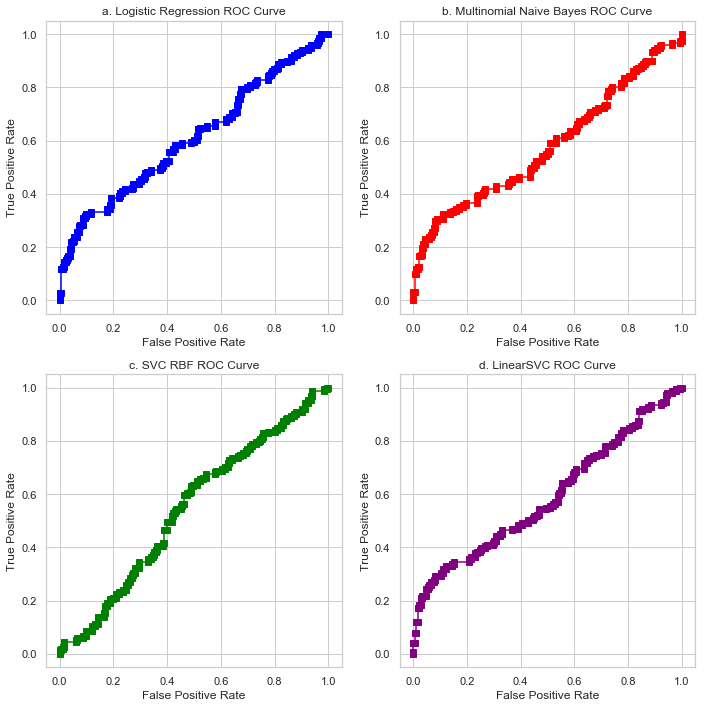

AUC for Logisitic Regression (MaxEnt): 0.609
AUC for Mulitnomial Naive Bayes: 0.581
AUC for SVC RBF: 0.545
AUC for LinearSVC: 0.590


In [332]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
#Setting test size to 20% of the data meaning it will be the last 333 entries.

#Logistic Regression
lr_y_score = log_reg.predict_proba(fardata[:333])[:,1]

f_positive, t_positive, thresholds = metrics.roc_curve(fartarget[:333],lr_y_score)
lr_roc_auc = metrics.auc(f_positive, t_positive)


fig, axes = plt.subplots(2, 2, figsize = (10,10))
fig.subplots_adjust(top=0.99, left=.01, right=0.99,
                    hspace=0.3, wspace=0.3)
fig.figsize = (10,10)
((ax1, ax2), (ax3, ax4)) = axes
ax1.set_title('a. Logistic Regression ROC Curve')
ax1.plot(f_positive, t_positive, c='blue', marker="s", label="Logistic Regression (MaxEnt)")
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')



#Multinomial Naive Bayes
mnb_y_score = mnb.predict_log_proba(fardata[:333])[:,1]

f_positive, t_positive, thresholds = metrics.roc_curve(fartarget[:333],mnb_y_score)
mnb_roc_auc = metrics.auc(f_positive, t_positive)

ax2.set_title('b. Multinomial Naive Bayes ROC Curve')
ax2.plot(f_positive, t_positive, c='red', marker="s", label="Multinomial Naive Bayes")
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')


#SVC RBF
svc_y_score = svc.decision_function(fardata[:333])

f_positive, t_positive, thresholds = metrics.roc_curve(fartarget[:333],svc_y_score)
svc_roc_auc = metrics.auc(f_positive, t_positive)


ax3.set_title('c. SVC RBF ROC Curve')
ax3.plot(f_positive, t_positive, c='green', marker="s", label="SVC RBF")
ax3.set_ylabel('True Positive Rate')
ax3.set_xlabel('False Positive Rate')



#LinearSVC
y_score = linear_svc_classifier.decision_function(fardata[:333])

f_positive, t_positive, thresholds = metrics.roc_curve(fartarget[:333],y_score)
roc_auc = metrics.auc(f_positive, t_positive)


ax4.set_title('d. LinearSVC ROC Curve')
ax4.plot(f_positive, t_positive, c='purple', marker="s", label="LinearSVC")
ax4.set_ylabel('True Positive Rate')
ax4.set_xlabel('False Positive Rate')
plt.tight_layout()
plt.show()



print("AUC for Logisitic Regression (MaxEnt): %.3f" % lr_roc_auc)
print("AUC for Mulitnomial Naive Bayes: %.3f" % mnb_roc_auc)
print("AUC for SVC RBF: %.3f" % svc_roc_auc)
print("AUC for LinearSVC: %.3f" % roc_auc)

In [340]:
from sklearn.model_selection import cross_val_predict
print("__Logisitc Regression (MaxEnt) Confusion Table__")
log_pred = cross_val_predict(log_reg, fardata, fartarget, cv=10)
print(metrics.confusion_matrix(fartarget,log_pred))

__Logisitc Regression (MaxEnt) Confusion Table__
[[547 283]
 [361 469]]


## Results
**Logistic Regression**

In [382]:
print(log_reg.coef_)
print(vectorizer.get_feature_names())
print(log_reg.intercept_)

[[ 0.0340191  -0.00043726 -0.00096415  0.26285652 -0.00572019  0.00521898
   0.23780356 -0.01127857 -0.03477583  0.00487631]]
['age', 'bodytype', 'day', 'landuse', 'modelyr', 'month', 'numoccs', 'statenum', 'vfatcount', 'year']
[-2.86776996e-05]


In [366]:
log_reg.get_params()

{'C': 100,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [337]:
log_reg_coef = pd.DataFrame(log_reg.coef_, columns = vectorizer.get_feature_names())
log_reg_coef.head()
log_reg_coef['intercept'] = log_reg.intercept_

In [389]:
import pickle
#Dumping Result into a pickle file
pickleoutput = open('Logistic_Regression_Coefs.pkl', 'wb')
pickle.dump(log_reg_coef, pickleoutput)
pickleoutput.close()

#Dumping Logistic Regression Model into pickle file
pickleoutput2 = open('Logistic_Regression_Model.pkl','wb')
pickle.dump(log_reg, pickleoutput2)
pickleoutput2.close()

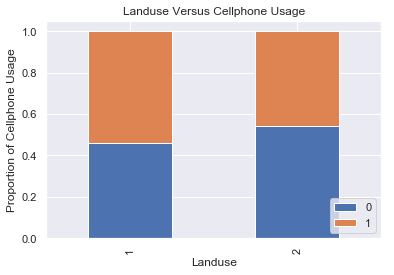

In [386]:
table=pd.crosstab(far_data["landuse"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Landuse Versus Cellphone Usage')
plt.xlabel('Landuse')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Landuse Versus Cellphone Usage')

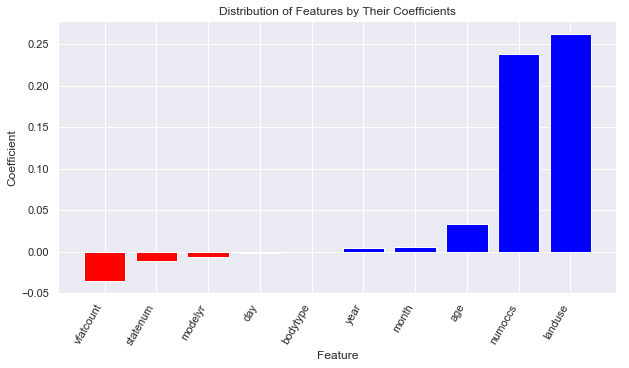

In [388]:
#Idea from:
'''A. Bakharia, “Visualising Top Features in Linear SVM with Scikit Learn and Matplotlib,” 
        Medium, 31-Jan-2016. [Online]. 
        Available: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matotlib-3454ab18a14d. 
        [Accessed: 29-Apr-2019].'''
coefs = log_reg.coef_.ravel()
pos_coefs = np.argsort(coefs)[-5:]
neg_coefs = np.argsort(coefs)[:5]
coefficients = np.hstack([neg_coefs, pos_coefs])
feat_names = vectorizer.get_feature_names()

 # create plot
plt.figure(figsize=(10, 5))
colors = ['red' if c < 0 else 'blue' for c in coefs[coefficients]]
plt.bar(np.arange(2 * 5), coefs[coefficients], color=colors)
feat_names = np.array(feat_names)
plt.xticks(np.arange(0, 2 * 5), feat_names[coefficients], rotation=60, ha='right')
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.title("Distribution of Features by Their Coefficients")
plt.show()